In [10]:
import re
import pandas as pd

# Function to extract date and time from each message
def date_time(message):
    pattern = r'\d{2}/\d{2}/\d{4}, \d{2}:\d{2}'
    match = re.search(pattern, message)
    if match:
        return match.group()
    return None

# Function to find unique contacts from the chat
def find_contacts(message):
    try:
        split_message = message.split(' - ')[1]  # Split into datetime and user+message
        user = split_message.split(': ')[0]  # Extract user
        return user
    except IndexError:
        return None

# Function to extract the actual message content
def get_message(message):
    try:
        split_message = message.split(' - ')[1]  # Split into datetime and user+message
        message_content = split_message.split(': ')[1]  # Extract message content
        return message_content
    except IndexError:
        return None

# Load the WhatsApp chat data from a file
def load_chat(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read().strip().split("\n")

# Function to parse the chat data and store it in a DataFrame
def parse_chat(chat_data):
    messages = []
    for message in chat_data:
        date = date_time(message)
        contact = find_contacts(message)
        msg = get_message(message)
        if date and contact and msg:
            messages.append([date, contact, msg])
    
    df = pd.DataFrame(messages, columns=['DateTime', 'Contact', 'Message'])
    return df

# Specify the path to your chat file
file_path = "BECOMPS.txt"

# Parse the chat
chat_data = load_chat(file_path)
df = parse_chat(chat_data)

# Convert DateTime to a proper datetime object
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%Y, %H:%M')

print(df.head())


             DateTime          Contact                          Message
0 2022-07-22 14:20:00  +91 98695 08978                  <Media omitted>
1 2022-07-25 11:12:00  +91 98212 94715                  <Media omitted>
2 2022-07-25 15:56:00  +91 98212 94715            A Batch 211201-211223
3 2022-07-25 17:21:00  +91 98212 94715                  <Media omitted>
4 2022-07-25 17:21:00  +91 98212 94715  Contact Noman sir in the office


In [11]:
import emoji
import re

# Function to preprocess the message text (remove emojis, unnecessary characters)
def preprocess(text):
    # Remove emojis
    text = emoji.replace_emoji(text, replace='')
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove non-alphanumeric characters (excluding spaces)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    return text

# Preprocess all messages
df['CleanMessage'] = df['Message'].apply(preprocess)

print(df[['Message', 'CleanMessage']].head())


                           Message                     CleanMessage
0                  <Media omitted>                    media omitted
1                  <Media omitted>                    media omitted
2            A Batch 211201-211223             a batch 211201211223
3                  <Media omitted>                    media omitted
4  Contact Noman sir in the office  contact noman sir in the office


In [14]:
from textblob import TextBlob

# Function to get sentiment from each message
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Add sentiment score to each message
df['Sentiment'] = df['CleanMessage'].apply(get_sentiment)

# Classify sentiment as Positive, Neutral, or Negative
def classify_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

df['SentimentCategory'] = df['Sentiment'].apply(classify_sentiment)

print(df[['CleanMessage', 'Sentiment', 'SentimentCategory']].head())


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 KB 2.8 MB/s eta 0:00:0000:0100:01
  Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
  Using cached regex-2024.9.11-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (782 kB)
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Using cached click-8.1.7-py3-none-any.whl (97 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 KB 1.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
                      CleanMessage  Sentiment SentimentCategory
0                    media omitted        0.0           Neutral
1                    media omitted        0.0           Neutral
2             a batch 211201211223        0.0           Neutral
3                    media omitted        0.0           Neutral
4  contact noman sir in the office        0.0           Neutral


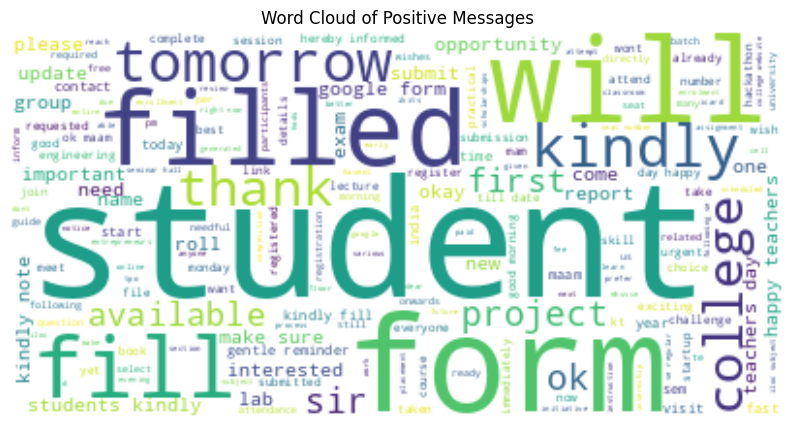

In [15]:
from wordcloud import WordCloud, STOPWORDS

# Create a word cloud for positive messages
positive_text = " ".join(df[df['SentimentCategory'] == 'Positive']['CleanMessage'].values)

wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(positive_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Messages')
plt.show()


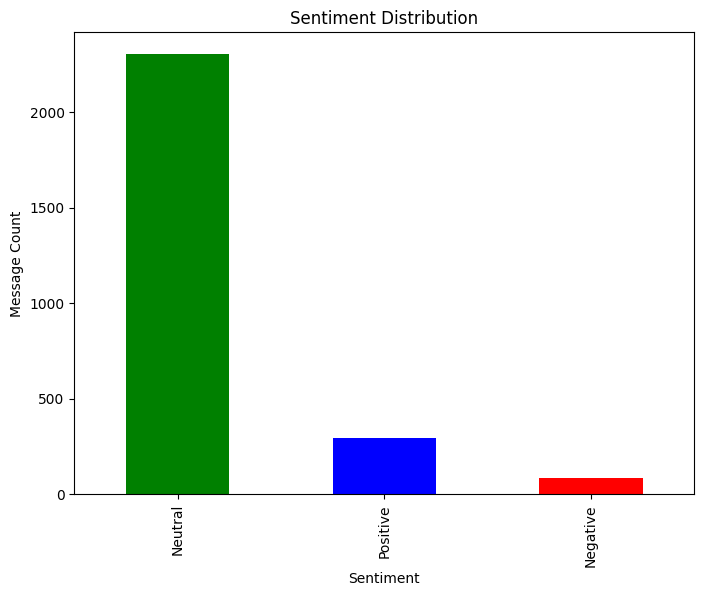

In [16]:
import matplotlib.pyplot as plt

# Plot the sentiment distribution
plt.figure(figsize=(8,6))
df['SentimentCategory'].value_counts().plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Message Count')
plt.show()
